In [61]:
import yaml

In [62]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [202]:
if menu['toolbox']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    import pint
    from pathlib import Path
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from rasterio.plot import show
    from rasterstats import zonal_stats
    from osgeo import gdal, gdalconst
    from scipy.ndimage import generic_filter
    from shapely.geometry import LineString
    from shapely.ops import linemerge, unary_union
    import fiona
    import osmnx as ox
    from shapely.geometry import LineString, mapping
    from skimage import measure
    from shapely.ops import unary_union
    from rasterstats import zonal_stats
    from affine import Affine
    from rasterio.features import geometry_mask
    import fiona
    from rasterio.crs import CRS
    import warnings
    from rasterio.merge import merge 
    from rasterio.transform import from_bounds
    import csv
    from shapely.geometry import LineString, MultiPoint
    from shapely.ops import split, snap
    from rasterio.mask import mask
    import rasterio.features
    from rasterio.enums import Resampling
    from rasterio.vrt import WarpedVRT
    from rasterio.features import shapes
    from shapely.geometry import shape

read AOI shapefile


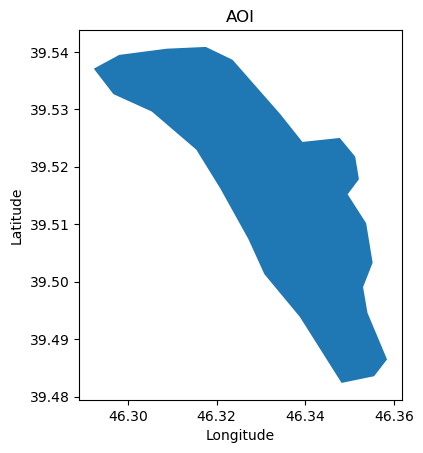

goris
armenia


In [64]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
plot_folder = Path(output_folder/'plots')
pickle_folder = Path(output_folder/'pickles')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print(city)
print(country)

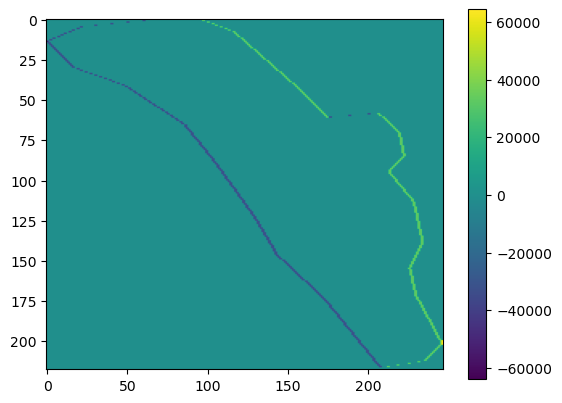

Slope calculation completed and saved to: mnt/city-directories/02-process-output/goris_slope.tif


In [7]:
#Slope
def get_slope():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    
    if menu['elevation']:  
        elev_path = os.path.join(output_folder, city + '_elevation.tiff')
        with rasterio.open(elev_path) as src:
            elev_data = src.read(1)  

            
            slope = np.gradient(elev_data)[1]

            
            plt.imshow(slope, cmap='viridis')
            plt.colorbar()
            plt.show()

            
            slope_path = os.path.join(output_folder, city + "_slope.tif")

            
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)

            
            profile = src.profile
            profile.update({
                'crs': 'EPSG:4326',
                'transform': transform,
                'width': width,
                'height': height
            })

            
            with rasterio.open(slope_path, 'w', **profile) as dst:
                \
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)
                
                
                dst.write(slope, 1)

            print("Slope calculation completed and saved to:", slope_path)

get_slope()

In [224]:
#merge pluvial 

def merge_pluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_pluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(pluvial_file) for pluvial_file in matching_files]
        
        try:
            merged_data, merged_transform = merge(src_files_to_merge)
            merged_crs = src_files_to_merge[0].crs
            
            output_file = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
            with rasterio.open(output_file, 'w', driver='GTiff',
                               width=merged_data.shape[2], height=merged_data.shape[1],
                               count=1, dtype=merged_data.dtype,
                               crs=merged_crs, transform=merged_transform) as dst:
                dst.write(merged_data)
    
            print(f"Merged pluvial data saved as {output_file}")
            return output_file
        except Exception as e:
            print(f"Error occurred while merging: {e}")
            return None
    else:
        print("Error: No pluvial files found.")
        return None


merged_pluvial_file = merge_pluvial_files()



Merged pluvial data saved as mnt/city-directories/02-process-output/goris_merged_pluvial_data.tif


In [225]:
#merge pluvial 

def merge_pluvial_files_UTM():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_pluvial_2020_*_utm.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(pluvial_file) for pluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_pluvial_data_utm.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged pluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No pluvial files found.")
        return None

merged_pluvial_file = merge_pluvial_files_UTM()


Merged pluvial data saved as mnt/city-directories/02-process-output/goris_merged_pluvial_data_utm.tif


In [226]:
def merge_fluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_fluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(fluvial_file) for fluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged fluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No fluvial files found.")
        return None

merged_fluvial_file = merge_fluvial_files()

Merged fluvial data saved as mnt/city-directories/02-process-output/goris_merged_fluvial_data.tif


In [227]:
def merge_fluvial_files_UTM():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_fluvial_2020_*_utm.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(fluvial_file) for fluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs  # Use the CRS of the first file

        output_file = os.path.join(output_folder, f"{city}_merged_fluvial_data_utm.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged fluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No fluvial files found.")
        return None
    
merged_fluvial_file = merge_fluvial_files_UTM()

Merged fluvial data saved as mnt/city-directories/02-process-output/goris_merged_fluvial_data_utm.tif


In [91]:
#merge comb files and save a merged file  (everything with a value is 1, otherwise 0 )

In [92]:
#merge coastal files and save a merged file  (everything with a value is 1, otherwise 0 )

In [12]:
#resampling data
def resample_raster(input_raster, target_shape):
    # Resample raster to match the target shape
    data = input_raster.read(1, out_shape=target_shape, resampling=Resampling.nearest)
    return data

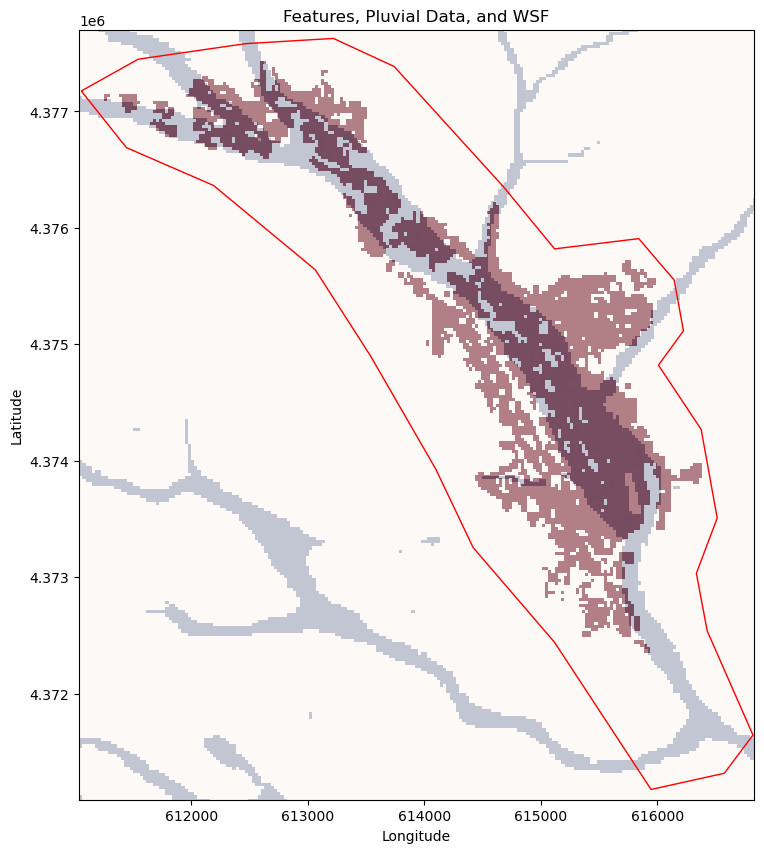

In [246]:
#PLOT CHECK
def plot_data():
    if menu.get('flood') and menu.get('wsf'):
        pluvial_path = os.path.join(output_folder, f"{city}_merged_pluvial_data_utm.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_utm.tiff")
    # Plot features
    fig, ax = plt.subplots(figsize=(10, 10))
    features_utm = features.to_crs('EPSG:32638')
    features_utm.plot(ax=ax, facecolor='none', edgecolor='red')
    

    # Plot pluvial data
    with rasterio.open(pluvial_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot WSF data
    with rasterio.open(wsf_path) as wsf_src:
        show(wsf_src, ax=ax, cmap='Reds', alpha=0.5)

    ax.set_title("Features, Pluvial Data, and WSF")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
    plt.savefig
plot_data()

Statistics by year saved to mnt/city-directories/02-process-output/goris_pu_wsf_areas_by_year.xlsx


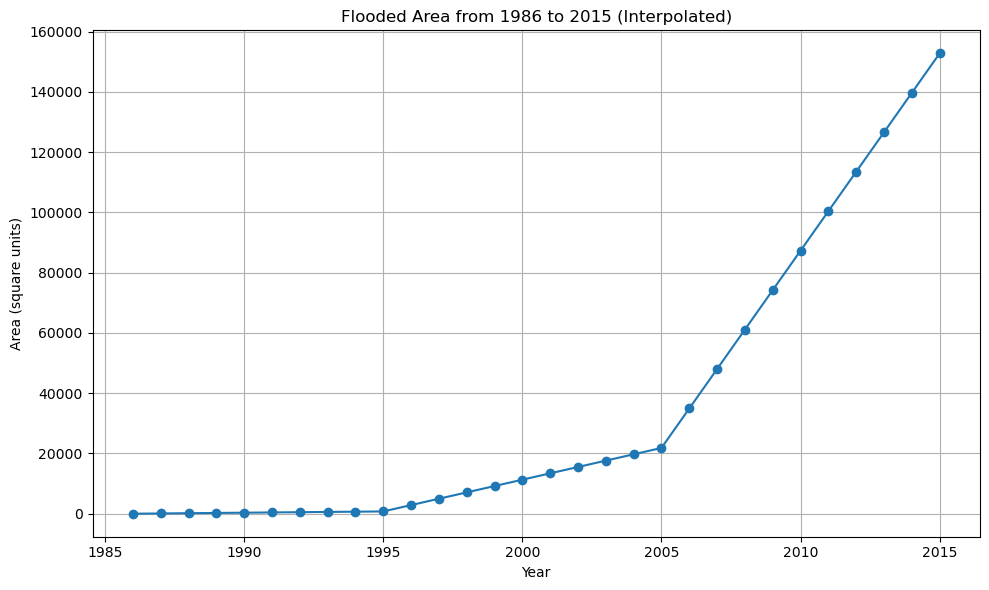

In 2015, 152792.80 sq.m of the city’s built-up area (15.33%) was exposed to surface water flooding.


In [237]:
#WSF and Pu

def get_pu_wsf():
    if menu.get('flood') and menu.get('wsf'):
        pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_lt1_utm.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_utm.tiff")

        # Reproject features to UTM
        features_utm = features.to_crs('EPSG:32638')  

        with rasterio.open(pu_path) as src_pluvial:
            pluvial_data, pluvial_transform = mask(src_pluvial, features_utm.geometry, crop=True)
            pluvial_data = pluvial_data[0]  
            pluvial_affine = pluvial_transform
            pluvial_resolution = abs(pluvial_transform[0] * pluvial_transform[4])  

        with rasterio.open(wsf_path) as src_wsf:
            wsf_data, wsf_transform = mask(src_wsf, features_utm.geometry, crop=True)
            wsf_data = wsf_data[0]  
            wsf_affine = wsf_transform

        
        min_height = min(pluvial_data.shape[0], wsf_data.shape[0])
        min_width = min(pluvial_data.shape[1], wsf_data.shape[1])
        pluvial_data = pluvial_data[:min_height, :min_width]
        wsf_data = wsf_data[:min_height, :min_width]

        
        unique_years = np.unique(wsf_data)
        unique_years = unique_years[unique_years != 0]
        unique_years = unique_years[unique_years != 1985]  

        stats_by_year = {}

        for year in unique_years:
            masked_wsf_data = np.where(wsf_data == year, 1, 0)
            masked_flooded_data = masked_wsf_data * pluvial_data
            stats = zonal_stats(features_utm.geometry, masked_flooded_data, affine=pluvial_transform, stats="sum", nodata=-9999)
            area = stats[0]['sum'] * pluvial_resolution  

            stats_by_year[year] = area

        return stats_by_year

    else:
        print("Flood or WSF menu not selected.")
        return None

# Stats by year
stats_by_year = get_pu_wsf()

if stats_by_year is not None:
    df = pd.DataFrame(stats_by_year.items(), columns=['Year', 'Area (square units)'])

    excel_file = os.path.join(output_folder, f"{city}_pu_wsf_areas_by_year.xlsx")

    df.to_excel(excel_file, index=False)
    
    print(f"Statistics by year saved to {excel_file}")
else:
    print("No statistics calculated.")

if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    # Filter years for plotting
    years_to_plot = [1986, 1995, 2005, 2015]
    areas_to_plot = [stats_by_year.get(year, np.nan) for year in years_to_plot]

    # Interpolate missing years' data for a smoother curve
    interp_years = np.arange(min(years_to_plot), max(years_to_plot) + 1)
    interp_areas = np.interp(interp_years, years_to_plot, areas_to_plot)

    plt.figure(figsize=(10, 6))
    plt.plot(interp_years, interp_areas, marker='o', linestyle='-')
    plt.title('Flooded Area from 1986 to 2015 (Interpolated)') #add cumulative stats and then plot 
    plt.xlabel('Year')
    plt.ylabel('Area (square units)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No areas calculated.")

# Calculate 2015 text
total_built_up_area = sum(stats_by_year.values())
flooded_area_2015 = stats_by_year.get(2015, 0)
percentage_2015 = (flooded_area_2015 / total_built_up_area) * 100
print(f"In 2015, {flooded_area_2015:.2f} sq.m of the city’s built-up area ({percentage_2015:.2f}%) was exposed to surface water flooding.")



In [247]:
# Function to calculate flooded area from WSF data
'''
def get_pu_wsf(output_folder, city, menu, features):
    if menu.get('flood') and menu.get('wsf'):
        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data_utm.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_utm.tiff")

        # Reproject features to UTM
        features_utm = features.to_crs('EPSG:32638')  

        with rasterio.open(pu_path) as src_pluvial:
            pluvial_data, pluvial_transform = mask(src_pluvial, features_utm.geometry, crop=True)
            pluvial_data = pluvial_data[0]  
            pluvial_affine = pluvial_transform
            pluvial_resolution = abs(pluvial_transform[0] * pluvial_transform[4])  

        with rasterio.open(wsf_path) as src_wsf:
            wsf_data, wsf_transform = mask(src_wsf, features_utm.geometry, crop=True)
            wsf_data = wsf_data[0]  
            wsf_affine = wsf_transform

            # Ensure both arrays have the same shape
            min_height = min(pluvial_data.shape[0], wsf_data.shape[0])
            min_width = min(pluvial_data.shape[1], wsf_data.shape[1])
            pluvial_data = pluvial_data[:min_height, :min_width]
            wsf_data = wsf_data[:min_height, :min_width]

        # Calculate flooded area for each year
        pixel_areas = {}
        unique_years = np.unique(wsf_data)
        for year in unique_years:
            if year != 0 and year >= 1986:  # Exclude background value and years before 1986
                # Mask WSF data for the current year
                masked_wsf_data = np.where(wsf_data == year, 1, 0)
                # Multiply with pluvial data to get flooded area
                masked_flooded_data = masked_wsf_data * pluvial_data
                # Calculate area
                area = np.count_nonzero(masked_flooded_data) * pluvial_resolution
                pixel_areas[year] = area

        return pixel_areas
    else:
        print("Flood or WSF menu not selected.")
        return None

# Call the function and print results
pu_wsf_areas = get_pu_wsf(output_folder, city, menu, features)
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    # Filter years for plotting
    years_to_plot = [1986, 1995, 2005, 2015]
    areas_to_plot = [stats_by_year.get(year, np.nan) for year in years_to_plot]

    # Interpolate missing years' data for a smoother curve
    interp_years = np.arange(min(years_to_plot), max(years_to_plot) + 1)
    interp_areas = np.interp(interp_years, years_to_plot, areas_to_plot)

    plt.figure(figsize=(10, 6))
    plt.plot(interp_years, interp_areas, marker='o', linestyle='-')
    plt.title('Flooded Area from 1986 to 2015 (Interpolated)')
    plt.xlabel('Year')
    plt.ylabel('Area (square units)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No areas calculated.")
'''


'\ndef get_pu_wsf(output_folder, city, menu, features):\n    if menu.get(\'flood\') and menu.get(\'wsf\'):\n        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data_utm.tif")\n        wsf_path = os.path.join(output_folder, f"{city}_wsf_utm.tiff")\n\n        # Reproject features to UTM\n        features_utm = features.to_crs(\'EPSG:32638\')  \n\n        with rasterio.open(pu_path) as src_pluvial:\n            pluvial_data, pluvial_transform = mask(src_pluvial, features_utm.geometry, crop=True)\n            pluvial_data = pluvial_data[0]  \n            pluvial_affine = pluvial_transform\n            pluvial_resolution = abs(pluvial_transform[0] * pluvial_transform[4])  \n\n        with rasterio.open(wsf_path) as src_wsf:\n            wsf_data, wsf_transform = mask(src_wsf, features_utm.geometry, crop=True)\n            wsf_data = wsf_data[0]  \n            wsf_affine = wsf_transform\n\n            # Ensure both arrays have the same shape\n            min_height = min(pl

Statistics by year saved to mnt/city-directories/02-process-output/goris_fu_wsf_areas_by_year.xlsx


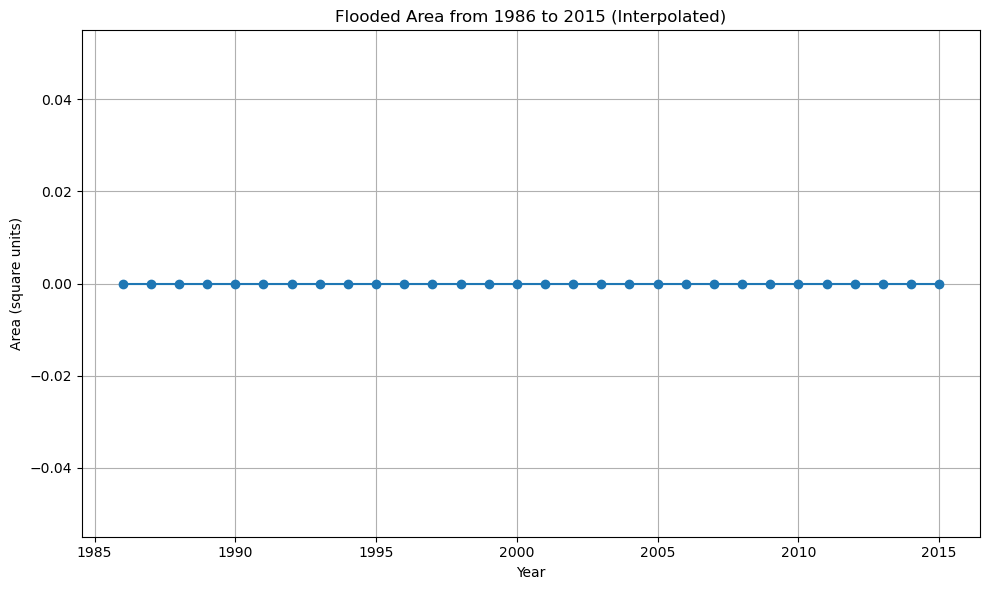

ZeroDivisionError: float division by zero

In [239]:
#Fluvial and WSF

def get_fu_wsf():
    if menu.get('flood') and menu.get('wsf'):
        fu_path = os.path.join(output_folder, f"{city}_fluvial_2020_lt1_utm.tif")  # Update the file path for fluvial data
        wsf_path = os.path.join(output_folder, f"{city}_wsf_utm.tiff")

        # Reproject features to UTM
        features_utm = features.to_crs('EPSG:32638')  

        with rasterio.open(fu_path) as src_fluvial:  # Open the fluvial data
            fluvial_data, fluvial_transform = mask(src_fluvial, features_utm.geometry, crop=True)
            fluvial_data = fluvial_data[0]  
            fluvial_affine = fluvial_transform
            fluvial_resolution = abs(fluvial_transform[0] * fluvial_transform[4])  

        with rasterio.open(wsf_path) as src_wsf:
            wsf_data, wsf_transform = mask(src_wsf, features_utm.geometry, crop=True)
            wsf_data = wsf_data[0]  
            wsf_affine = wsf_transform

        # Ensure both arrays have the same shape
        min_height = min(fluvial_data.shape[0], wsf_data.shape[0])
        min_width = min(fluvial_data.shape[1], wsf_data.shape[1])
        fluvial_data = fluvial_data[:min_height, :min_width]
        wsf_data = wsf_data[:min_height, :min_width]

        # Get unique years from the WSF data
        unique_years = np.unique(wsf_data)
        unique_years = unique_years[unique_years != 0]
        unique_years = unique_years[unique_years != 1985]  

        stats_by_year = {}

        for year in unique_years:
            masked_wsf_data = np.where(wsf_data == year, 1, 0)
            masked_flooded_data = masked_wsf_data * fluvial_data  
            stats = zonal_stats(features_utm.geometry, masked_flooded_data, affine=fluvial_transform, stats="sum", nodata=-9999)
            area = stats[0]['sum'] * fluvial_resolution  

            stats_by_year[year] = area

        return stats_by_year

    else:
        print("Flood or WSF menu not selected.")
        return None

# Call the function to get the statistics by year for fluvial data
stats_by_year_fluvial = get_fu_wsf()

if stats_by_year_fluvial is not None:
    df = pd.DataFrame(stats_by_year_fluvial.items(), columns=['Year', 'Area (square units)'])

    excel_file = os.path.join(output_folder, f"{city}_fu_wsf_areas_by_year.xlsx")

    df.to_excel(excel_file, index=False)
    
    print(f"Statistics by year saved to {excel_file}")
else:
    print("No statistics calculated.")

if stats_by_year_fluvial is not None:
    years = list(stats_by_year_fluvial.keys())
    areas = list(stats_by_year_fluvial.values())

    # Filter years for plotting
    years_to_plot = [1986, 1995, 2005, 2015]
    areas_to_plot = [stats_by_year_fluvial.get(year, np.nan) for year in years_to_plot]

    # Interpolate missing years' data for a smoother curve
    interp_years = np.arange(min(years_to_plot), max(years_to_plot) + 1)
    interp_areas = np.interp(interp_years, years_to_plot, areas_to_plot)

    plt.figure(figsize=(10, 6))
    plt.plot(interp_years, interp_areas, marker='o', linestyle='-')
    plt.title('Flooded Area from 1986 to 2015 (Interpolated)')
    plt.xlabel('Year')
    plt.ylabel('Area (square units)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No areas calculated.")

# Calculate the total built-up area for all years
total_built_up_area_fu = sum(stats_by_year_fluvial.values())

# Determine the flooded area in 1985
flooded_area_2015_fu = stats_by_year.get(2015, 0)

# Calculate the percentage of the built-up area exposed to surface water flooding in 1985
percentage_2015_fu = (flooded_area_2015_fu / total_built_up_area_fu) * 100

# Print the statement
print(f"In 2015, {flooded_area_2015_fu:.2f} sq.m of the city’s built-up area ({percentage_2015_fu:.2f}%) was exposed to surface water flooding.")




In [96]:
#Do the same for comb files

In [97]:
#Do the same for coastal files 

In [289]:
#Population Pluvial #Bramka's reference

def normalize_raster(src, dst_shape):
    """
    Normalize the raster to a consistent shape using WarpedVRT.
    """
    src_profile = src.profile
    src_profile['count'] = 1  # Ensure only one band is read
    with WarpedVRT(src, **src_profile) as vrt:
        data = vrt.read(1, out_shape=dst_shape)
    return data

def get_pu_pop_norm():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('population'):
        pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_lt1.tif")
        try:
            with rasterio.open(pu_path) as pu_src:
                pu_shape = pu_src.shape
                merged_pluvial_data = pu_src.read(1)
                merged_pluvial_data_transform = pu_src.transform
        except Exception as e:
            print(f"Error opening merged pluvial data raster: {e}")
            return

        pop_path = os.path.join(output_folder, f"{city}_population.tif")
        try:
            with rasterio.open(pop_path) as pop_src:
                pop_data = normalize_raster(pop_src, pu_shape)
                pop_transform = pop_src.transform
        except Exception as e:
            print(f"Error opening population raster: {e}")
            return
        

        pop_data_clipped = np.clip(pop_data, 0, None)
        pop_percentile_60 = np.percentile(pop_data_clipped, 60)

        total_count = np.sum((merged_pluvial_data == 1) & (pop_data_clipped > pop_percentile_60))
        total_pixels = np.sum(merged_pluvial_data == 1)

        percentage = (total_count / total_pixels) * 100
        print(f"{percentage:.2f}% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm")

        csv_path = os.path.join(output_folder, 'pu_pop_area.csv')
        df = pd.DataFrame({'File Name': 'Combined', 'Percentage': [percentage]})
        df.to_csv(csv_path, index=False)
        print(f"Result saved to {csv_path}")
    else:
        print("Flood or population menu not selected.")

get_pu_pop_norm()


9.90% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/pu_pop_area.csv


In [283]:
#Population Fluvial

def normalize_raster(src, dst_shape):
    """
    Normalize the raster to a consistent shape using WarpedVRT.
    """
    src_profile = src.profile
    src_profile['count'] = 1  # Ensure only one band is read
    with WarpedVRT(src, **src_profile) as vrt:
        data = vrt.read(1, out_shape=dst_shape)
    return data

def get_fu_pop_norm():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('population'):
        fu_path = os.path.join(output_folder, f"{city}_fluvial_2020_lt1.tif")
        try:
            with rasterio.open(fu_path) as fu_src:
                fu_shape = fu_src.shape
                merged_fluvial_data = fu_src.read(1)
                merged_fluvial_data_transform = fu_src.transform
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return

        pop_path = os.path.join(output_folder, f"{city}_population.tif")
        try:
            with rasterio.open(pop_path) as pop_src:
                pop_data = normalize_raster(pop_src, fu_shape)
                pop_transform = pop_src.transform
        except Exception as e:
            print(f"Error opening population raster: {e}")
            return

        pop_data_clipped = np.clip(pop_data, 0, None)
        pop_percentile_60 = np.percentile(pop_data_clipped, 60) #60 

        total_count = np.sum((merged_fluvial_data == 1) & (pop_data_clipped > pop_percentile_60))
        total_pixels = np.sum(merged_fluvial_data == 1)

        percentage = (total_count / total_pixels) * 100
        print(f"{percentage:.2f}% of densely populated areas are located within the fluvial flood risk zone with a minimum depth of 10 cm")

        csv_path = os.path.join(output_folder, 'fu_pop_area.csv')
        df = pd.DataFrame({'File Name': 'Combined', 'Percentage': [percentage]})
        df.to_csv(csv_path, index=False)
        print(f"Result saved to {csv_path}")
    else:
        print("Flood or population menu not selected.")

get_fu_pop_norm()

6.72% of densely populated areas are located within the fluvial flood risk zone with a minimum depth of 10 cm
Result saved to mnt/city-directories/02-process-output/fu_pop_area.csv


In [209]:
# Pu Amenities

def get_pu_am():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_lt1.tif")
        try:
            with rasterio.open(pu_path) as pu_src:
                merged_pluvial_data = pu_src.read(1)
                merged_pluvial_data_transform = pu_src.transform
                merged_pluvial_data_shape = merged_pluvial_data.shape
        except Exception as e:
            print(f"Error opening merged pluvial data raster: {e}")
            return

        
        stats_list = []
        for category in ['health', 'police', 'fire','schools']:
            shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_osm_{category}.shp")
            try:
                amenities = gpd.read_file(shapefile_path)

                with rasterio.open(pu_path) as src:
                    affine = src.transform

                stats = zonal_stats(amenities, merged_pluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

                count_overlap = sum([feature["properties"]["count"] for feature in stats])
                total_count = len(amenities)
                percentage = (count_overlap / total_count) * 100

                stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

                print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

            except Exception as e:
                if category == 'fire':
                    print("Fire stations do not exist")
                else:
                    print(f"Error processing {category} shapefile: {e}")
        
        df = pd.DataFrame(stats_list)
        
        
        excel_file = os.path.join(output_folder, 'pu_osmpt.xlsx')
        df.to_excel(excel_file, index=False)
        print(f"Statistics saved to {excel_file}")

# Suppress warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

get_pu_am()


Error processing health shapefile: mnt/city-directories/02-process-output/goris_osm_health/goris_osm_health.shp: No such file or directory
2 of 3 (66.67%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
6 of 10 (60.00%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/pu_osmpt.xlsx


In [159]:
#PU Roads
'''
def get_pu_roads():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # File paths
    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_lt1.tif")
    roads_path = os.path.join('output/goris_edges.shp')

    # Read pluvial data
    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  # Get the affine transformation
            nodata_value = pu_src.nodata  # Get the nodata value
    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    # Read roads data
    try:
        roads = gpd.read_file(roads_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return
    # Filter highways from the roads dataset
    highways = roads[roads['highway'] == 'primary']

    # Convert length to meters
    highways['length_m'] = highways['geometry'].length

    # Get the total length of highways
    total_length_highways = highways['length_m'].sum()

    # Perform zonal stats to get length of flooded highways
    try:
        stats = zonal_stats(highways.geometry, merged_pluvial_data, affine=transform, nodata=nodata_value, stats="max")
        total_length_flooded_highways = sum([s['max'] for s in stats if s['max'] is not None])
        print(f"Total length of highways flooded due to pluvial conditions: {total_length_flooded_highways:.2f} meters")
        
        # Calculate percentage of flooded roads
        if total_length_highways > 0:
            percentage_flooded_roads = (total_length_flooded_highways / total_length_highways) * 100
            print(f"Percentage of highways flooded due to pluvial conditions: {percentage_flooded_roads:.2f}%")
        else:
            print("No highways found.")
        
    except Exception as e:
        print(f"Error calculating zonal statistics: {e}")
        return

# Call the function
get_pu_roads()
'''

Total length of highways flooded due to pluvial conditions: 7.00 meters
Percentage of highways flooded due to pluvial conditions: 17086.72%


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_16886/745275645.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  highways['length_m'] = highways['geometry'].length
/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_16886/1980665401.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersections['length'] = intersections.length


Total length of highways intersecting pluvial data: 0.04 meters
Percentage of highways intersecting pluvial data: 0.0011%


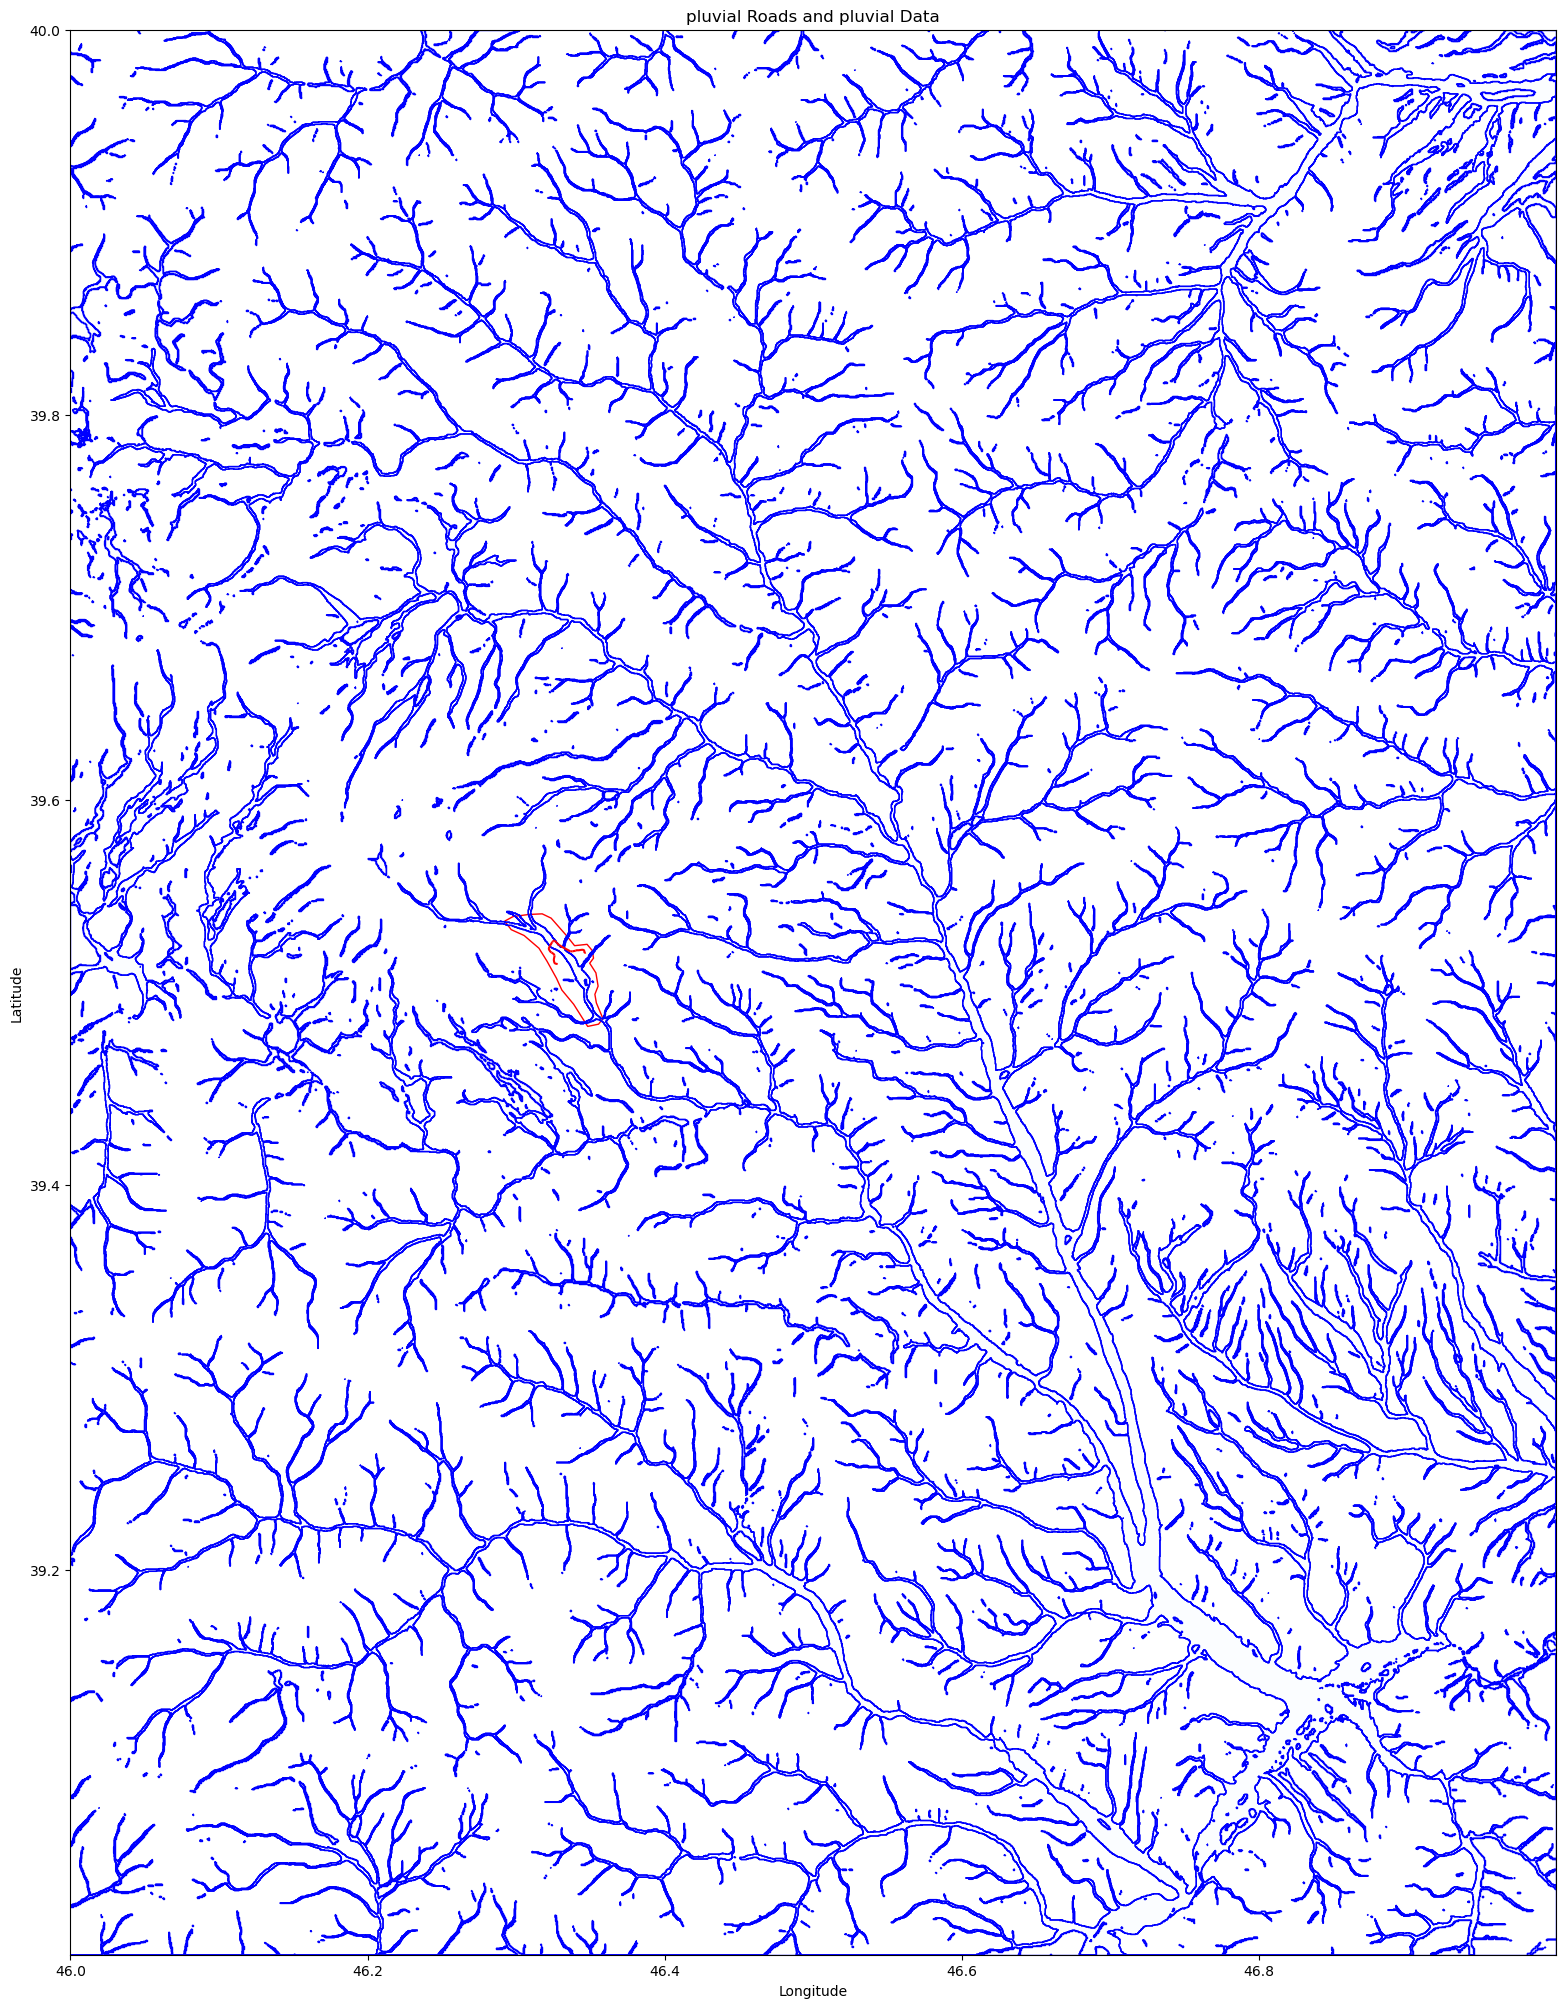

In [291]:
#Pluvial Roads
def get_pu_roads():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pu_path = os.path.join(output_folder, f"{city}_pluvial_2020_lt1.tif")
    roads_path = os.path.join('output/goris_edges.shp')

    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  
            nodata_value = pu_src.nodata  

            shapes_gen = shapes(merged_pluvial_data, transform=transform)
            merged_pluvial_polygons = [shape(shape_item) for shape_item, _ in shapes_gen]
            pluvial_geometry = gpd.GeoDataFrame(geometry=merged_pluvial_polygons, crs=pu_src.crs)

    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    try:
        roads = gpd.read_file(roads_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return
    roads = roads.to_crs(pluvial_geometry.crs)

    # Filter highways with specific keywords in the "highway" column
    highways_filtered = roads[(roads["highway"] == 'primary') | 
                              (roads["highway"] == 'trunk') | 
                              (roads["highway"] == 'motorway')]

    # Explode the filtered highways to smaller fragments
    exploded_highways = highways_filtered.explode(index_parts=False)
    
    intersections = gpd.overlay(exploded_highways, pluvial_geometry, how='intersection')

    intersections['length'] = intersections.length
    
    total_length = intersections['length'].sum()
    
    total_length_highways = exploded_highways['length'].sum()

    percentage = (total_length / total_length_highways) * 100
    
    print(f"Total length of highways intersecting pluvial data: {total_length:.2f} meters")
    print(f"Percentage of highways intersecting pluvial data: {percentage:.4f}%")
# Plot fluvial data and roads
    fig, ax = plt.subplots(figsize=(25, 25))

    

    # Plot fluvial data
    with rasterio.open(pu_path) as pluvial_src:
        show(pluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot fluvial roads
    exploded_highways.plot(ax=ax, facecolor='none', edgecolor='red')
    features.plot(ax=ax, facecolor='none', edgecolor='red')
    pluvial_geometry.plot(ax=ax, facecolor='none', edgecolor='blue')

    ax.set_title("pluvial Roads and pluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

    
    

get_pu_roads()


In [134]:
# Fu Amenities

def get_fu_am():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        fu_path = os.path.join(output_folder, f"{city}_fluvial_2020_lt1.tif")
        try:
            with rasterio.open(fu_path) as fu_src:
                merged_fluvial_data = fu_src.read(1)
                merged_fluvial_transform = fu_src.transform
                merged_fluvial_shape = merged_fluvial_data.shape
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return

        
        stats_list = []
        for category in ['health', 'police', 'fire','schools']:
            shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_osm_{category}.shp")
            try:
                amenities = gpd.read_file(shapefile_path)

                with rasterio.open(fu_path) as src:
                    affine = src.transform

                stats = zonal_stats(amenities, merged_fluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

                count_overlap = sum([feature["properties"]["count"] for feature in stats])
                total_count = len(amenities)
                percentage = (count_overlap / total_count) * 100

                stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

                print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

            except Exception as e:
                if category == 'fire':
                    print("Fire stations do not exist")
                else:
                    print(f"Error processing {category} shapefile: {e}")
        
        df = pd.DataFrame(stats_list)
        
        
        excel_file = os.path.join(output_folder, 'fu_osmpt.xlsx')
        df.to_excel(excel_file, index=False)
        print(f"Statistics saved to {excel_file}")

# Suppress warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

get_fu_am()


Error processing health shapefile: mnt/city-directories/02-process-output/goris_osm_health/goris_osm_health.shp: No such file or directory
0 of 3 (0.00%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
0 of 10 (0.00%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/fu_osmpt.xlsx


Total length of highways flooded due to pluvial conditions: 0.00 meters
Percentage of highways flooded due to pluvial conditions: 0.00%


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_16886/2759718682.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  highways['length_m'] = highways['geometry'].length
/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


NameError: name 'exploded_highways' is not defined

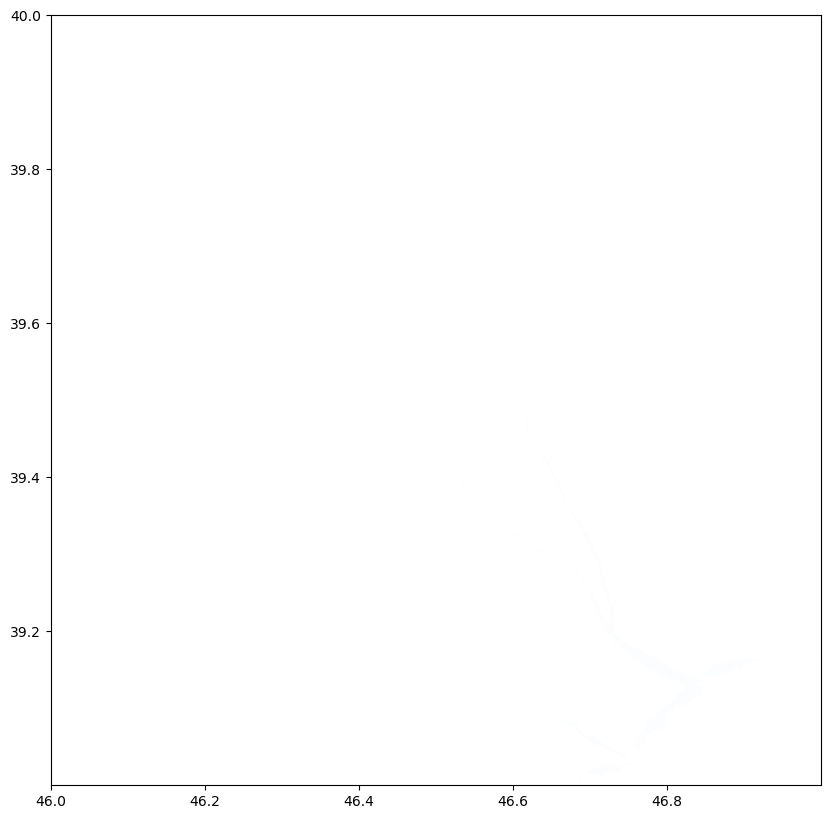

In [274]:
#FU Roads

def get_fu_roads():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # File paths
    fu_path = os.path.join(output_folder, f"{city}_fluvial_2020_lt1.tif")
    roads_path = os.path.join('output/goris_edges.shp')

    # Read fluvial data
    try:
        with rasterio.open(fu_path) as fu_src:
            merged_fluvial_data = fu_src.read(1)
            transform = fu_src.transform  # Get the affine transformation
            nodata_value = fu_src.nodata  # Get the nodata value
    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    # Read roads data
    try:
        roads = gpd.read_file(roads_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return
    # Filter highways from the roads dataset
    highways = roads[roads['highway'] == 'primary']

    # Convert length to meters
    highways['length_m'] = highways['geometry'].length

    # Get the total length of highways
    total_length_highways = highways['length_m'].sum()

    # Perform zonal stats to get length of flooded highways
    try:
        stats = zonal_stats(highways.geometry, merged_fluvial_data, affine=transform, nodata=nodata_value, stats="max")
        total_length_flooded_highways = sum([s['max'] for s in stats if s['max'] is not None])
        print(f"Total length of highways flooded due to pluvial conditions: {total_length_flooded_highways:.2f} meters")
        
        # Calculate percentage of flooded roads
        if total_length_highways > 0:
            percentage_flooded_roads = (total_length_flooded_highways / total_length_highways) * 100
            print(f"Percentage of highways flooded due to pluvial conditions: {percentage_flooded_roads:.2f}%")
        else:
            print("No highways found.")
        
    except Exception as e:
        print(f"Error calculating zonal statistics: {e}")
        return

# Plot fluvial data and roads
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot fluvial data
    with rasterio.open(fu_path) as fluvial_src:
        show(fluvial_src, ax=ax, cmap='Blues', alpha=0.5)

    # Plot fluvial roads
    exploded_highways.plot(ax=ax, facecolor='none', edgecolor='red')
    features.plot(ax=ax, facecolor='none', edgecolor='red')

    ax.set_title("Fluvial Roads and Fluvial Data")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
# Call the function
get_fu_roads()



In [ ]:
#Comb WSF

In [ ]:
#Comb Population

In [ ]:
#Comb Amenities

In [ ]:
#Coastal WSF

In [ ]:
#Coastal Population

In [ ]:
#Coastal Amenities